In [ ]:
import time
from pathlib import Path

import matplotlib.pyplot as plt

from utils.func_epinetmodel import define_epinet
from utils.func_makeinput import make_multiinput
from utils.func_pfm import read_pfm, write_pfm

# --- Configuration ---

# 1. Paths
# Path to trained weights file (.hdf5 or .keras)
MODEL_WEIGHTS_PATH = 'models/checkpoints/iter0002_trainmse9.728_bp38.80.keras'

# Example: "data/hci_dataset/training/dino" or "data/lytro/2067"
INPUT_DIR = 'data/hci_dataset/training/cotton'

# Directory to save the output PFM files
OUTPUT_DIR = 'results'

# 2. Image Settings
# Set to 'synthetic' (512x512) or 'lytro' (552x383)
DATASET_TYPE = 'synthetic'

# 3. View Settings
# "5x5" or "9x9"
VIEW_MODE = '9x9'

# --- Derived Parameters ---
if DATASET_TYPE.lower() == 'synthetic':
    IMAGE_HEIGHT = 512
    IMAGE_WIDTH = 512
elif DATASET_TYPE.lower() == 'lytro':
    IMAGE_HEIGHT = 383
    IMAGE_WIDTH = 552
else:
    IMAGE_HEIGHT = 512
    IMAGE_WIDTH = 512

if VIEW_MODE == '9x9':
    ANGULAR_VIEWS = [0, 1, 2, 3, 4, 5, 6, 7, 8]
else:
    ANGULAR_VIEWS = [2, 3, 4, 5, 6]

Path(OUTPUT_DIR).mkdir(parents=True, exist_ok=True)

print(
    f'Configuration Set:\nType: {DATASET_TYPE} ({IMAGE_WIDTH}x{IMAGE_HEIGHT})\nViews: {VIEW_MODE}\nWeights: {MODEL_WEIGHTS_PATH}'
)

2026-01-18 20:34:43.168906: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Configuration Set:
Type: synthetic (512x512)
Views: 5x5
Weights: models/checkpoints/iter0002_trainmse9.728_bp38.80.keras


/home/tiberiu/Documents/TAID/FC/epinet/.venv/lib/python3.13/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


In [2]:
# 1. Build Model
print('Building Model...')
model = define_epinet(
    sz_input_h=IMAGE_HEIGHT,
    sz_input_w=IMAGE_WIDTH,
    view_n=ANGULAR_VIEWS,
    conv_depth=7,
    filt_num=70,
    learning_rate=0.1e-3,
)

# 2. Load Weights
print(f'Loading weights from: {MODEL_WEIGHTS_PATH}')
try:
    model.load_weights(MODEL_WEIGHTS_PATH)
except OSError:
    print('Error: Weight file not found. Check the path in Cell 1.')
    raise

# 3. Prepare Input
print(f'Processing directory: {INPUT_DIR}')
try:
    # Prepare 4-stream input (90d, 0d, 45d, -45d)
    (val_90d, val_0d, val_45d, val_m45d) = make_multiinput(
        INPUT_DIR, IMAGE_HEIGHT, IMAGE_WIDTH, ANGULAR_VIEWS
    )
except NameError:
    print('Error: make_multiinput not defined. Check imports in Cell 3.')
    raise

# 4. Predict
print('Running prediction...')
start_time = time.perf_counter()

pred_output = model.predict(
    [val_90d, val_0d, val_45d, val_m45d], batch_size=1, verbose=1
)

runtime = time.perf_counter() - start_time
print(f'Prediction complete in {runtime:.4f} seconds.')

# 5. Save Output
output_filename = f'{Path(INPUT_DIR).name}.pfm'
output_path = Path(OUTPUT_DIR) / output_filename
disparity_map = pred_output[0, :, :, 0]

write_pfm(disparity_map, str(output_path))
print(f'Saved disparity map to: {output_path}')

Building Model...


/home/tiberiu/Documents/TAID/FC/epinet/.venv/lib/python3.13/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1768761286.948407   35500 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 766 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5


Model: "functional_102"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_stack_90d     │ (None, 512, 512,  │          0 │ -                 │
│ (InputLayer)        │ 5)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_stack_0d      │ (None, 512, 512,  │          0 │ -                 │
│ (InputLayer)        │ 5)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_stack_45d     │ (None, 512, 512,  │          0 │ -                 │
│ (InputLayer)        │ 5)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_stack_M45d    │ (None, 512, 512,  │          0 │ -                 │
│ (InputLayer)        │ 5)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 506, 506,  │    100,660 │ input_stack_90d[… │
│ (Sequential)        │ 70)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, 506, 506,  │    100,660 │ input_stack_0d[0… │
│ (Sequential)        │ 70)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_2        │ (None, 506, 506,  │    100,660 │ input_stack_45d[… │
│ (Sequential)        │ 70)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_3        │ (None, 506, 506,  │    100,660 │ input_stack_M45d… │
│ (Sequential)        │ 70)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mid_merged          │ (None, 506, 506,  │          0 │ sequential[0][0], │
│ (Concatenate)       │ 280)              │            │ sequential_1[0][… │
│                     │                   │            │ sequential_2[0][… │
│                     │                   │            │ sequential_3[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_4        │ (None, 492, 492,  │  4,402,160 │ mid_merged[0][0]  │
│ (Sequential)        │ 280)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_5        │ (None, 490, 490,  │    315,001 │ sequential_4[0][… │
│ (Sequential)        │ 1)                │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,119,801 (19.53 MB)

 Trainable params: 5,114,201 (19.51 MB)

 Non-trainable params: 5,600 (21.88 KB)

Loading weights from: models/checkpoints/iter0002_trainmse9.728_bp38.80.keras


/home/tiberiu/Documents/TAID/FC/epinet/.venv/lib/python3.13/site-packages/keras/src/saving/saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 2 variables whereas the saved optimizer has 120 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


ValueError: A total of 4 objects could not be loaded. Example error message for object <Conv2D name=S1_c10, built=True>:

The shape of the target variable and the shape of the target value in `variable.assign(value)` must match. variable.shape=(2, 2, 5, 70), Received: value.shape=(2, 2, 9, 70). Target variable: <Variable path=sequential/S1_c10/kernel, shape=(2, 2, 5, 70), dtype=float32, value=[[[[ 0.00338055 -0.07355496  0.0625546  ...  0.02348971  0.14070918
     0.03947066]
   [-0.06202398  0.0705075  -0.13265222 ... -0.03642128  0.11787693
    -0.05589576]
   [ 0.0632019   0.07886185  0.00308606 ... -0.07629524 -0.1213863
    -0.01435868]
   [ 0.10675423 -0.00227515  0.01807122 ...  0.01457916 -0.129702
     0.04748349]
   [-0.03351372 -0.01666554  0.10831019 ... -0.04794585  0.10004799
    -0.04882365]]

  [[-0.09733963  0.11269273 -0.06474933 ... -0.09907211 -0.00824274
    -0.07410482]
   [ 0.10754153 -0.13388011  0.1165552  ...  0.12573178 -0.00084391
     0.14134659]
   [ 0.00987713 -0.11827883  0.08160254 ...  0.10918359 -0.03373481
    -0.06195567]
   [ 0.01131441 -0.12000533 -0.05012134 ... -0.13840516  0.02694212
     0.11037071]
   [ 0.1100968  -0.12779108 -0.06049752 ... -0.03881402 -0.1398744
     0.12170388]]]


 [[[-0.04574133  0.05497538  0.09246534 ... -0.0047141  -0.05095039
    -0.04583588]
   [ 0.12519975 -0.0923076  -0.10310145 ...  0.00064829  0.00423384
     0.04601946]
   [-0.1157624  -0.1193234   0.1137218  ...  0.13258718  0.1370338
     0.07703048]
   [ 0.07976356 -0.12592089  0.07510042 ...  0.05597186 -0.08075492
     0.11636268]
   [-0.03862941  0.10387014  0.06082118 ...  0.07485105  0.12889011
     0.11216535]]

  [[-0.11120231 -0.00289606 -0.12950446 ...  0.06437749 -0.06518786
     0.04003155]
   [ 0.04068294  0.01287128  0.02152501 ... -0.11009708  0.06043498
     0.04550657]
   [ 0.11659373 -0.134608   -0.06738934 ... -0.00621265  0.00495711
     0.08382531]
   [-0.13557562 -0.13333267  0.03457421 ... -0.04366663  0.08891188
     0.03822395]
   [ 0.03314027 -0.10937098  0.01801771 ...  0.09584345  0.01474398
     0.13457681]]]]>

List of objects that could not be loaded:
[<Conv2D name=S1_c10, built=True>, <Conv2D name=S1_c10, built=True>, <Conv2D name=S1_c10, built=True>, <Conv2D name=S1_c10, built=True>]

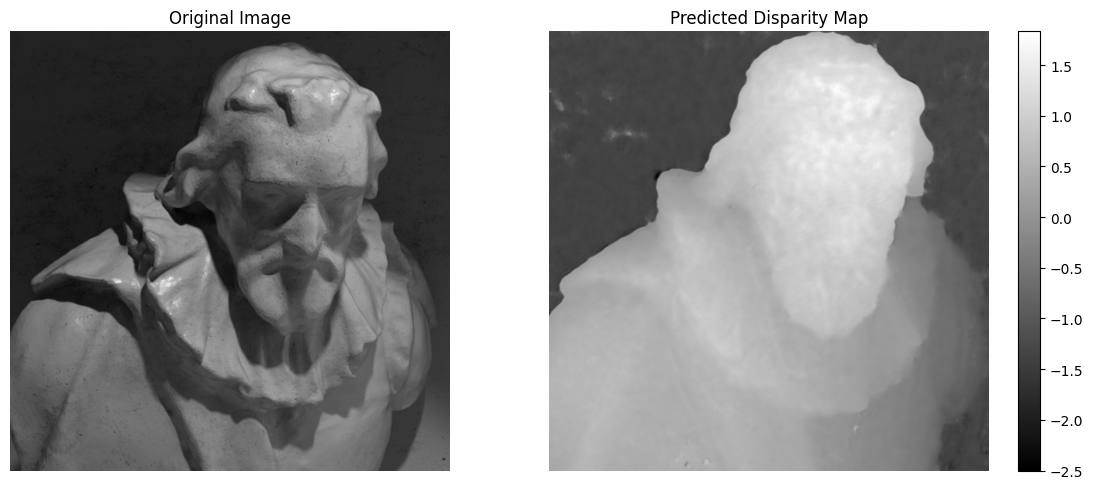

In [3]:
# Pick the first sample and first angular view
original_img = val_0d[0, :, :, 0]

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(original_img, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Predicted Disparity Map')
plt.imshow(disparity_map, cmap='gray')
plt.colorbar()
plt.axis('off')

plt.tight_layout()
plt.show()


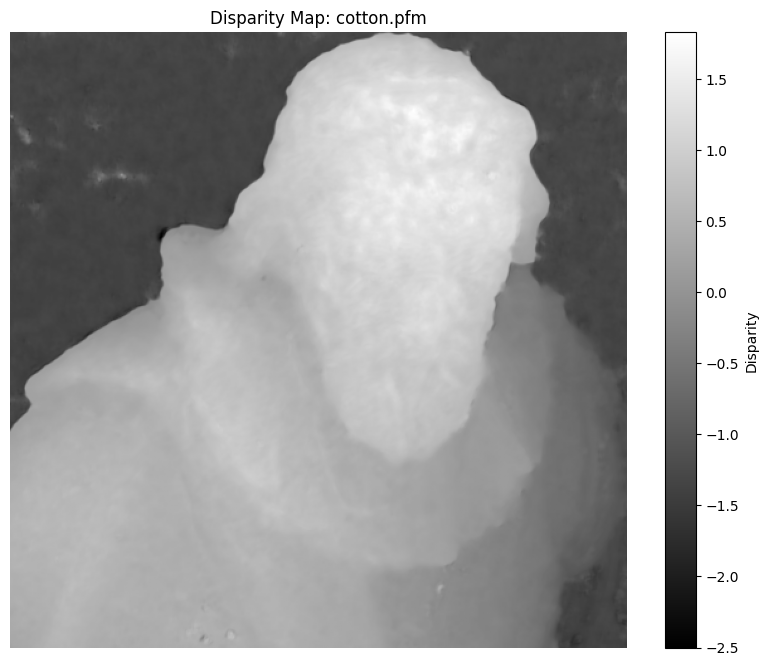

In [4]:
output_path = Path(OUTPUT_DIR) / f'{Path(INPUT_DIR).name}.pfm'

if output_path.exists():
    try:
        disparity_data = read_pfm(str(output_path), expected_identifier='Pf')

        plt.figure(figsize=(10, 8))
        plt.imshow(disparity_data, cmap='gray')
        plt.colorbar(label='Disparity')
        plt.title(f'Disparity Map: {output_path.name}')
        plt.axis('off')
        plt.show()

    except Exception as e:
        print(f'Error reading PFM: {e}')
        print("Retrying with expected_identifier='PF' (Color)...")
        try:
            disparity_data = read_pfm(str(output_path), expected_identifier='PF')
            plt.imshow(disparity_data)
            plt.show()
        except Exception as e2:
            print(f'Retry failed: {e2}')
else:
    print(f'Output file not found at {output_path}. Run the prediction cell first.')